In [15]:
import pandas as pd
import os
import numpy as np
import seaborn as sns
from collections import Counter
import matplotlib.pyplot as plt
from Levenshtein import distance as levenshtein_distance

In [16]:
# Read in Metadata
basefolder = ""
datafolder = ""
plotsfolder = 'plots'

In [28]:
vdj = pd.read_csv(os.path.join(basefolder,'vdj_humanTRB_score1_12_06_23.tsv'), delimiter='\t')

def get_similarities(tcrs_to_analyze):
    vdj_columns = ['Epitope', 'Epitope species', 'Score', 'MHC A', 'MHC B', 'MHC class']
    similarities = pd.DataFrame(columns=['CDR3', 'VDJ_CDR3'].extend(vdj_columns))

    for cdr3 in set(tcrs_to_analyze['cdr3_b_aa']):
        if cdr3 in vdj['CDR3']:
            print(cdr3, vdj[vdj.CDR3 == cdr3]['Epitope'])
        for vdj_cdr3 in vdj['CDR3']:
            dist = levenshtein_distance(cdr3, vdj_cdr3)
            if dist <= 1:
                vdj_subset = vdj[vdj.CDR3 == vdj_cdr3][vdj_columns]
                vdj_subset['CDR3'] = [cdr3 for x in vdj_subset['Epitope']]
                vdj_subset['VDJ_CDR3'] = [vdj_cdr3 for x in vdj_subset['Epitope']]
                similarities = pd.concat([similarities, vdj_subset])
    return similarities
print(len(vdj), Counter(vdj['Epitope species']))

8350 Counter({'CMV': 1978, 'HIV-1': 1358, 'EBV': 1073, 'HomoSapiens': 1002, 'InfluenzaA': 944, 'SARS-CoV-2': 755, 'HCV': 511, 'Wheat': 138, 'HSV-2': 136, 'HTLV-1': 72, 'DENV1': 70, 'synthetic': 68, 'M.tuberculosis': 64, 'DENV3/4': 56, 'TriticumAestivum': 33, 'YFV': 28, 'DENV2': 19, 'Homo sapiens': 10, 'MCPyV': 10, 'E.Coli': 4, 'HIV1': 4, 'HPV-16': 4, 'HIV': 3, 'SaccharomycesCerevisiae': 2, 'HHV': 2, 'SelaginellaMoellendorffii': 2, 'PseudomonasFluorescens': 2, 'PseudomonasAeruginosa': 2})


In [18]:
def get_epitope(cdr3, similarities):
    if cdr3 in set(similarities['CDR3']):
        epitope = similarities[similarities['CDR3'] == cdr3]['Epitope species'].values[0]
    else:
        epitope = 'None'
    return epitope

In [19]:
# Search VDJdb for suspicious 49 TCRs
tcrs_to_analyze = pd.read_csv(os.path.join(basefolder,'resulting_TCRs/', 'clustering1and3_top1000_highandmedconf.csv'))

similarities = get_similarities(tcrs_to_analyze)
similarities = similarities.drop_duplicates(subset=['CDR3', 'Epitope'])

print(len(similarities), len(set(similarities['CDR3'])), len(tcrs_to_analyze), len(set(tcrs_to_analyze['cdr3_b_aa'])))

30 26 1526 1526


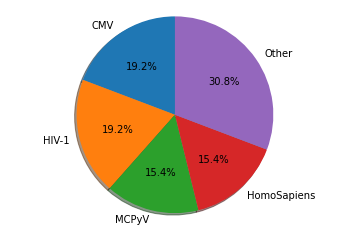

In [20]:
epitope_occur = Counter(similarities.drop_duplicates(subset='CDR3')['Epitope species'])
cutoff = 3
epitope_occur_labels = [x for x in epitope_occur.keys() if epitope_occur[x] > cutoff]
epitope_occur_labels.append('Other')
epitope_occur_sizes = [epitope_occur[x] for x in epitope_occur.keys() if epitope_occur[x] > cutoff]
epitope_occur_sizes.append(np.sum([epitope_occur[x] for x in epitope_occur.keys() if epitope_occur[x] <= cutoff]))
epitope_occur_labels,epitope_occur_sizes, epitope_occur

# Med and High conf 

# Pie chart, where the slices will be ordered and plotted counter-clockwise:
fig1, ax1 = plt.subplots()
ax1.pie(epitope_occur_sizes, labels=epitope_occur_labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.savefig(os.path.join(basefolder, plotsfolder, 'epitope_species_save.pdf'))

In [21]:
tcrs_to_analyze_clusters = pd.read_csv(os.path.join(basefolder,'resulting_tcrs', 'clustering1and3_top1000_highandmedconf_clusters.csv'))
def get_cluster(cdr3):
    return tcrs_to_analyze_clusters[tcrs_to_analyze_clusters['cdr3_b_aa'] == cdr3]['cluster'].values[0]

similarities['cluster'] = similarities['CDR3'].apply(lambda x: get_cluster(x))

In [24]:
tcrs_with_hits = tcrs_to_analyze_clusters[tcrs_to_analyze_clusters['cdr3_b_aa'].isin(similarities['CDR3'])]
tcrs_with_hits['Hit Epitope'] = tcrs_with_hits['cdr3_b_aa'].apply(lambda x: similarities[similarities['CDR3'] == x]['Epitope'].values[0])
tcrs_with_hits['Hit Epitope Species'] = tcrs_with_hits['cdr3_b_aa'].apply(lambda x: similarities[similarities['CDR3'] == x]['Epitope species'].values[0])
tcrs_with_hits['Hit Score'] = tcrs_with_hits['cdr3_b_aa'].apply(lambda x: similarities[similarities['CDR3'] == x]['Score'].values[0])
tcrs_with_hits['Hit MHC A'] = tcrs_with_hits['cdr3_b_aa'].apply(lambda x: similarities[similarities['CDR3'] == x]['MHC A'].values[0])
tcrs_with_hits['Hit MHC B'] = tcrs_with_hits['cdr3_b_aa'].apply(lambda x: similarities[similarities['CDR3'] == x]['MHC B'].values[0])

tcrs_with_hits.drop(['Unnamed: 0', 'Unnamed: 0.1', 'GCA', 'ID', 'InTop1000'], axis=1, inplace=True)
#tcrs_with_hits.to_csv(os.path.join(basefolder, 'tcr_specificity_hits.csv'))

/Users/wbr/opt/anaconda3/envs/leeds/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/wbr/opt/anaconda3/envs/leeds/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/wbr/opt/anaconda3/envs/leeds/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slic

In [25]:
len(tcrs_with_hits)

26

In [26]:
len(similarities['CDR3']), len(set(similarities['CDR3']))

(30, 26)

In [27]:
similarities[similarities['Epitope species'] == 'HomoSapiens']

,Epitope,Epitope species,Score,MHC A,MHC B,MHC class,CDR3,VDJ_CDR3,cluster
3716,KVDPIGHVY,HomoSapiens,2,HLA-A*01:01,B2M,MHCI,CASSQDRGYGYTF,CASSFDRGYGYTF,6
5849,GEEDGAGGHSL,HomoSapiens,2,HLA-B*44:02,B2M,MHCI,CASSQAGGDTGELFF,CASSQAGGTGELFF,7
387,GELIGILNAAKVPAD,HomoSapiens,3,HLA-DRA*01:01:02,HLA-DRB1*01:01:01,MHCII,CASSQERETQYF,CASSQIRETQYF,6
509,GQVELGGGNAVEVCKGS,HomoSapiens,3,HLA-DQA1*03:01,HLA-DQB1*03:02,MHCII,CASSQERETQYF,CASSLERETQYF,6
2528,ALYGFVPVL,HomoSapiens,2,HLA-A*02:01,B2M,MHCI,CASSQGAGDEQFF,CASSQGGDEQFF,1
